       config     acc  correct_confidence  incorrect_confidence  \
0           0  0.8427               0.934                 0.675   
1           1  0.9320               0.988                 0.867   
2           2  0.8500               0.930                 0.675   
3           3  0.8550               0.916                 0.648   
4           4  0.8663               0.933                 0.672   
...       ...     ...                 ...                   ...   
15620   15620  0.8551               0.916                 0.640   
15621   15621  0.8775               0.964                 0.760   
15622   15622  0.9230               0.987                 0.832   
15623   15623  0.6810               0.805                 0.579   
15624   15624  0.8478               0.925                 0.669   

                                                    arch  pre_ECE_5  \
0      |avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~...   0.046592   
1      |nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~

/var/folders/r_/l_hs4rds3yb6q8tzpr7x2_n00000gn/T/ipykernel_3444/774795915.py:53: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="no_paras", y="pre_ECE_15", data=df, ax=ax[0], linewidth=0,
/var/folders/r_/l_hs4rds3yb6q8tzpr7x2_n00000gn/T/ipykernel_3444/774795915.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the layout to make room for the color bar


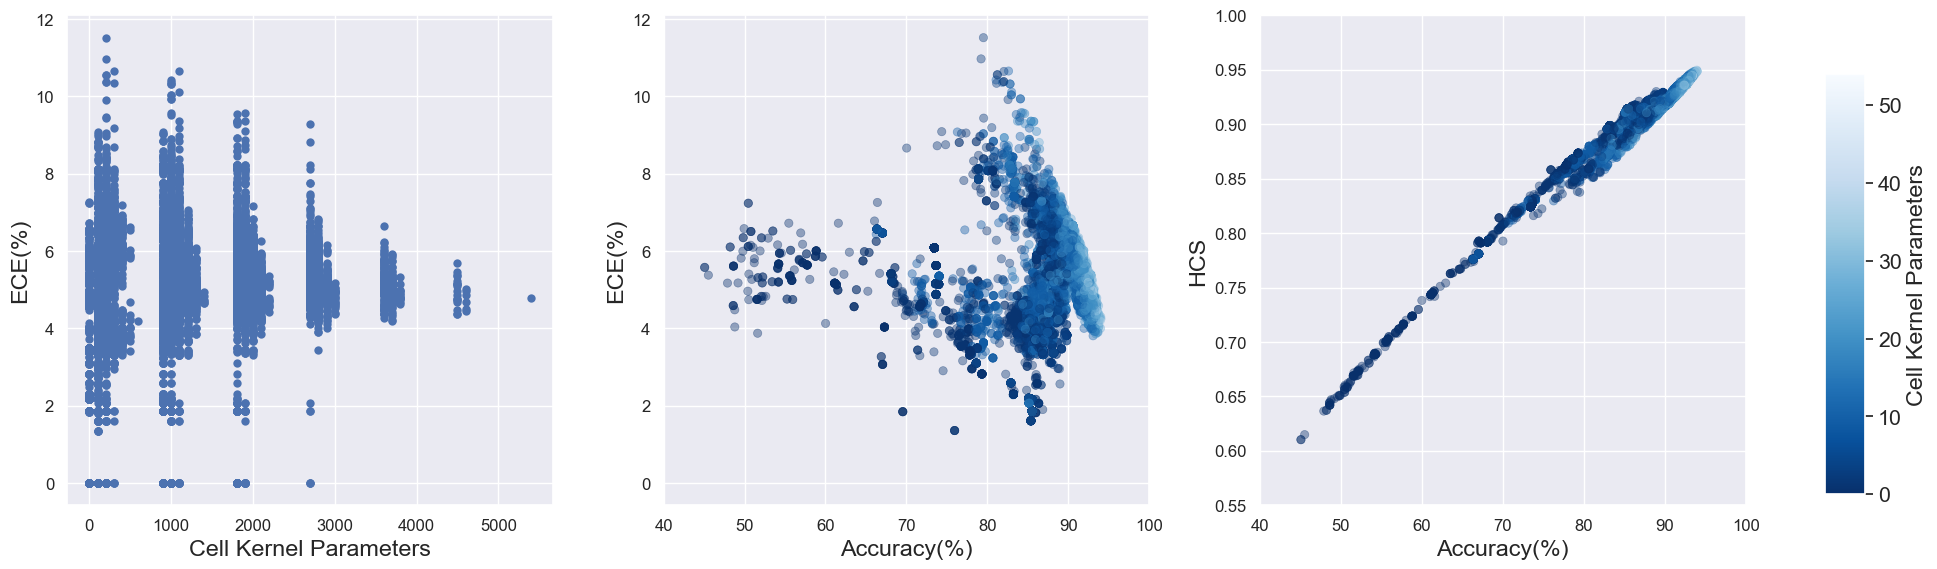

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from figure_main_paper.robustness_dataset import RobustnessDataset
from matplotlib.cm import ScalarMappable

# Load the data into a pandas DataFrame
df = pd.read_csv("../cifar10_tss.csv")

print(df)

data = RobustnessDataset(path="robustness-dataset")
no_paras = []
for idx in df.index:
    arch = data.id_to_string(int(idx))
    # print(arch)
    edge = [arch.split('+')[0][1:-1], arch.split('+')[1][1:-1].split("|")[0], arch.split('+')[1][1:-1].split("|")[1],
            arch.split('+')[2][1:-1].split("|")[0], arch.split('+')[2][1:-1].split("|")[1],
            arch.split('+')[2][1:-1].split("|")[2]]
    temp_paras = 0
    for item in edge:
        if item.startswith("nor_conv_3x3"):
            temp_paras += 9
        elif item.startswith("nor_conv_1x1"):
            temp_paras += 1
    no_paras.append(temp_paras)
    # print(edge)
df["no_paras"] = no_paras
acc = df["acc"]
ece = df["pre_ECE_15"]

hrs_ece = 2 * (acc * (1 - ece))/(acc + (1-ece))
df["hrs_ece"] = hrs_ece

beta = 1
hrs_ece_beta = (1 + beta) * (acc * (1 - ece))/(beta * acc + (1-ece))

df["hrs_ece_beta"] = hrs_ece_beta



# Set the seaborn style and font scale
sns.set(style="whitegrid")
sns.set(font_scale=1.4)
min_no_paras, max_no_paras = df['no_paras'].min(), df['no_paras'].max()
# Create a color palette based on reds
red_map = sns.color_palette("Blues_r", as_cmap=True)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Scatter plot 1
sns.scatterplot(x="no_paras", y="pre_ECE_15", data=df, ax=ax[0], linewidth=0,
                palette=red_map)
ax[0].set_xlabel("Cell Kernel Parameters")
ax[0].set_ylabel("ECE(%)")


# Scatter plot 2
scatter_plot = sns.scatterplot(y="pre_ECE_15", x="acc", hue="no_paras", data=df,
                ax=ax[1], palette=red_map, alpha=0.4, edgecolor='face', legend=False)
ax[1].set_xlabel("Accuracy(%)")
ax[1].set_ylabel("ECE(%)")
scatter_plot.set_xlim(0.4, 1)

# Scatter plot 3
scatter_plot = sns.scatterplot(y="hrs_ece_beta", x="acc", hue="no_paras", data=df,
                ax=ax[2], palette=red_map, alpha=0.4, edgecolor='face', legend=False)
ax[2].set_xlabel("Accuracy(%)")
ax[2].set_ylabel("HCS")
scatter_plot.set_ylim(0.55, 1)
scatter_plot.set_xlim(0.4, 1)

# Add color bar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(ScalarMappable(cmap=red_map, norm=plt.Normalize(vmin=min_no_paras, vmax=max_no_paras)), cax=cbar_ax)
cbar.set_label("Cell Kernel Parameters")

formatter = ticker.FuncFormatter(lambda x, _: f'{x*100:.0f}')
tick_fontsize = 12

for i, axes in enumerate(ax):
    axes.xaxis.set_major_formatter(formatter)
    if axes != ax[-1]:
        axes.yaxis.set_major_formatter(formatter)
    axes.tick_params(axis='both', labelsize=tick_fontsize)


plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the layout to make room for the color bar
# plt.savefig('./cell_params.pdf')
plt.show()

